<a href="https://colab.research.google.com/github/KalikaKay/Thinkful-Notebooks/blob/main/Data_Cleaning_Dept_of_Educ_Part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#head

In [ ]:
def listNull(df):
  #Take a look at the nulls. 
  null_columns=df.columns[df.isnull().any()]
  return df[df.isnull().any(axis=1)][null_columns]

In [ ]:
def fractionNull(df):
  #fraction of missing values for each value.
  return df.isnull().sum()*100/df.isnull().count()

In [ ]:
#Setup dataframe and visualizations
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


#Figure set up for dark theme:
plt.style.use(['dark_background'])
sns.set()

#suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [ ]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492.000000,1.229000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.229000e+03,1.280000e+03,1319.000000,1360.000000,1361.000000,1361.000000,1361.00000,1.361000e+03,1.361000e+03,1.319000e+03,536.000000,532.000000,533.000000,498.000000
mean,2004.433646,9.159308e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.292046e+05,9.027693e+05,17601.614102,63746.761029,64538.927259,64271.057311,54268.92432,5.192140e+05,2.470714e+05,8.024415e+05,234.768293,278.414711,218.866154,263.661132
std,7.393983,1.065280e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.340693e+05,1.327562e+06,30016.166447,80205.138143,80293.387625,78910.545776,67889.27623,6.436384e+05,3.077056e+05,9.707031e+05,10.221511,10.159722,7.769616,6.803725
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,1.270800e+04,0.000000,544.000000,633.000000,437.000000,311.00000,4.878000e+03,1.808000e+03,7.254000e+03,187.134670,232.831510,178.557612,236.379102
25%,1998.000000,2.583140e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,1.028310e+05,1.815645e+05,2021.000000,11745.000000,13739.000000,13342.000000,10919.00000,1.106260e+05,5.147100e+04,1.810650e+05,229.694352,272.761598,214.663401,259.533171
50%,2004.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.715960e+05,5.102595e+05,8106.000000,41597.500000,43272.000000,43339.000000,36735.00000,3.457750e+05,1.642600e+05,5.503420e+05,237.238552,280.618803,220.416034,265.010912
75%,2011.000000,1.014528e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.186000e+05,9.668515e+05,22295.000000,73865.250000,75481.000000,76566.000000,67460.00000,6.119050e+05,2.905020e+05,9.282755e+05,241.995486,285.347428,223.999337,268.190121
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,1.022366e+07,250911.000000,530531.000000,493415.000000,500143.000000,498403.00000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,280.499130


#Department of Education - Data Cleaning

A bit of work with data cleaning on a database from kaggle. More information about the dataset is available [here](https://www.kaggle.com/noriuk/us-education-datasets-unification-project). 

Develop a strategy for handling missing values. 

Which variables are you going impute, interpolate, or extrapolate? 

Which variables are you going to toss out?

Investigate and review the various methods in order to determine which methods work best for the situation(s).

##Investigating Data Types

**Determine all the variable types and find the fraction of the missing values
for each variable.**


A review of the data frame appears as though the data was imported correctly. I see that we have two object types, PRIMARY_KEY and STATE. These two objects are, in fact, strings. The rest of the data is in either integer or float form.

The minimum number of null values is at about 9% and the max is 64%. 
It looks like have to do a lot of cleaning. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PRIMARY_KEY                   1492 non-null   object 
 1   STATE                         1492 non-null   object 
 2   YEAR                          1492 non-null   int64  
 3   ENROLL                        1229 non-null   float64
 4   TOTAL_REVENUE                 1280 non-null   float64
 5   FEDERAL_REVENUE               1280 non-null   float64
 6   STATE_REVENUE                 1280 non-null   float64
 7   LOCAL_REVENUE                 1280 non-null   float64
 8   TOTAL_EXPENDITURE             1280 non-null   float64
 9   INSTRUCTION_EXPENDITURE       1280 non-null   float64
 10  SUPPORT_SERVICES_EXPENDITURE  1280 non-null   float64
 11  OTHER_EXPENDITURE             1229 non-null   float64
 12  CAPITAL_OUTLAY_EXPENDITURE    1280 non-null   float64
 13  GRA

In [ ]:
#fraction of missing values for each value.
df.isnull().sum()*100/df.isnull().count()

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          17.627346
TOTAL_REVENUE                   14.209115
FEDERAL_REVENUE                 14.209115
STATE_REVENUE                   14.209115
LOCAL_REVENUE                   14.209115
TOTAL_EXPENDITURE               14.209115
INSTRUCTION_EXPENDITURE         14.209115
SUPPORT_SERVICES_EXPENDITURE    14.209115
OTHER_EXPENDITURE               17.627346
CAPITAL_OUTLAY_EXPENDITURE      14.209115
GRADES_PK_G                     11.595174
GRADES_KG_G                      8.847185
GRADES_4_G                       8.780161
GRADES_8_G                       8.780161
GRADES_12_G                      8.780161
GRADES_1_8_G                     8.780161
GRADES_9_12_G                    8.780161
GRADES_ALL_G                    11.595174
AVG_MATH_4_SCORE                64.075067
AVG_MATH_8_SCORE                64.343164
AVG_READING_4_SCORE             64

##Strategy for Missing Values
*Notice: The data has a time dimension (year). For this part of the assignment, forget about time and treat all the observations as if they're from the same year.* 

**Separate the dataframe according to Kaggle**

*I may not always be this lucky, but today I am, so I'm using it*

The data has a primary_key. It is a combination of the state and year. Include state and year in each dataframe.

___
1.  Finances Revenue 
2.  Finances Expenditure
2.  Scores (Includes Math and Reading Scores) 
4.  Population or Enrollment

The data is comparable on the enrollment column. I will start with the enrollment dataframe.



In [ ]:
#Take a look at the nulls. 
null_columns=df.columns[df.isnull().any()]
df[df.isnull().any(axis=1)][null_columns]

,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.041059,290.081407,227.598382,273.402640
1488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.701001,289.131257,223.123409,267.744778
1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.057019,273.415854,217.316396,271.617023
1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.389213,288.143144,219.612694,258.700304


In [ ]:
df.groupby(by='YEAR').describe()

ENROLL                               ... AVG_READING_8_SCORE                        
      count           mean           std  ...                 50%         75%         max
YEAR                                      ...                                            
1992    0.0            NaN           NaN  ...          263.394780  265.029619  266.419687
1993   51.0  802054.333333  9.296589e+05  ...                 NaN         NaN         NaN
1994   51.0  801383.960784  8.501653e+05  ...                 NaN         NaN         NaN
1995   51.0  858973.039216  9.552881e+05  ...                 NaN         NaN         NaN
1996   51.0  873930.607843  9.796513e+05  ...          262.614403  266.991593  272.647106
1997   51.0  888379.745098  1.002225e+06  ...                 NaN         NaN         NaN
1998   51.0  897509.058824  1.021120e+06  ...                 NaN         NaN         NaN
1999   51.0  905101.470588  1.036834e+06  ...                 NaN         NaN         NaN
2000   51.0  910446.705882  1.050941e+06  ...          264.723046  267.957116  272.913745
2001   51.0  916296.274510  1.066472e+06  ...                 NaN         NaN         NaN
2002   51.0  923818.196078  1.083161e+06  ...                 NaN         NaN         NaN
2003   51.0  933396.862745  1.100523e+06  ...          264.532051  267.548736  272.906645
2004   51.0  938327.117647  1.110574e+06  ...                 NaN         NaN         NaN
2005   51.0  942259.960784  1.117298e+06  ...          263.938418  266.854985  273.716063
2006   51.0  947078.980392  1.124021e+06  ...                 NaN         NaN         NaN
2007   51.0  949109.254902  1.126345e+06  ...          263.545716  267.432255  273.284049
2008   54.0  942987.444444  1.100953e+06  ...                 NaN         NaN         NaN
2009   52.0  928904.730769  1.120431e+06  ...          264.943546  267.949434  273.589290
2010   52.0  929039.903846  1.122594e+06  ...                 NaN         NaN         NaN
2011   51.0  946587.745098  1.128972e+06  ...          265.697028  268.887751  275.368518
2012   51.0  945379.392157  1.130132e+06  ...                 NaN         NaN         NaN
2013   51.0  947012.176471  1.133663e+06  ...          267.272975  270.133047  277.009559
2014   51.0  948607.529412  1.138403e+06  ...                 NaN         NaN         NaN
2015   51.0  951263.450980  1.143913e+06  ...          266.806728  268.472358  277.191363
2016   51.0  952388.764706  1.145918e+06  ...                 NaN         NaN         NaN
2017    0.0            NaN           NaN  ...          266.330441  268.841526  280.499130

[26 rows x 176 columns]

###NOTICE ON DROP VALUES

*The null values account for less than 5% of the total dataset*

*50% or more of the variables in the row are null*
___

There's neither enrollment nor financial data for the year 2017. 

What I know about the data:

* NAEP test score data is only available for certain years.
* The column 'ENROLL' represents the U.S. Census Bureau data value (financial data). 'GRADES_ALL' represents the NCES data value (demographic data). Though the two organizations correspond on this matter, these values (which are ostensibly the same) do vary due to differences in membership (i.e. what is and is not a fourth grade student).

REASONING: More than 50% of the variables are missing. It accounts for less than 5% of the data.

DECISION: Delete the information for 2017. 



 

In [ ]:
#Remove 2017 data from the dataframe.
df = df[df['YEAR'] < 2017]

###Enroll Table

The enroll variable is the Census Bureau's Estimate for enrollment for the state.

In [ ]:
#Build an enroll dataframe.
enroll = df[['STATE', 'YEAR', 'ENROLL', 'GRADES_PK_G', 'GRADES_KG_G','GRADES_4_G','GRADES_8_G','GRADES_12_G','GRADES_1_8_G','GRADES_9_12_G','GRADES_ALL_G' ]]
fractionNull(enroll)

STATE             0.000000
YEAR              0.000000
ENROLL           14.712006
GRADES_PK_G       8.466343
GRADES_KG_G       5.621096
GRADES_4_G        5.551700
GRADES_8_G        5.551700
GRADES_12_G       5.551700
GRADES_1_8_G      5.551700
GRADES_9_12_G     5.551700
GRADES_ALL_G      8.466343
dtype: float64

####IMPUTATION

IMPUTATION says fill the variable in with the mean of the value.

In [ ]:
#Looking at imputation on the enroll variable.
impute = enroll
impute["ENROLL"].fillna(impute["ENROLL"].mean(), inplace=True)
impute.loc[:,['STATE', 'YEAR',"ENROLL", 'GRADES_ALL_G']].groupby(by="YEAR").mean()

,ENROLL,GRADES_ALL_G
YEAR,,
1992,915930.820993,726734.666667
1993,812221.876874,738159.000000
1994,811611.359017,749170.222222
1995,864058.555446,760743.777778
1996,878351.682912,764874.909091
1997,891279.858350,773816.636364
1998,899732.374947,769850.535714
1999,906569.857084,777501.660714
2000,911190.314711,784420.321429


In [ ]:
#By State
impute.loc[:,['STATE', "ENROLL", 'GRADES_ALL_G']].groupby(by="STATE").mean()

,ENROLL,GRADES_ALL_G
STATE,,
ALABAMA,7.437582e+05,684874.750000
ALASKA,1.618497e+05,121257.708333
AMERICAN_SAMOA,9.159308e+05,14252.714286
ARIZONA,8.759864e+05,878631.708333
ARKANSAS,4.704631e+05,428071.458333
...,...,...
VIRGIN_ISLANDS,9.159308e+05,NaN
WASHINGTON,1.006897e+06,937770.333333
WEST_VIRGINIA,3.142004e+05,267491.250000


In [ ]:
#Quick and Easy Solution!
fractionNull(impute)

STATE            0.000000
YEAR             0.000000
ENROLL           0.000000
GRADES_PK_G      8.466343
GRADES_KG_G      5.621096
GRADES_4_G       5.551700
GRADES_8_G       5.551700
GRADES_12_G      5.551700
GRADES_1_8_G     5.551700
GRADES_9_12_G    5.551700
GRADES_ALL_G     8.466343
dtype: float64

The enroll variable has been cleaned for the enroll table; however - when I do a quick comparison on the GRADES_ALL_G variable against the ENROLL variable, I find that the two are too far apart to hold a true comparison.  

####INTERPOLATION

Interpolate 'guesses' the values based on the data surrounding it. It's better for timely values, such as all of the variables in the enroll table. 


In [ ]:
#Looking at interpolation on the enroll variable.
terp = df[['STATE', 'YEAR', 'ENROLL', 'GRADES_PK_G', 'GRADES_KG_G','GRADES_4_G','GRADES_8_G','GRADES_12_G','GRADES_1_8_G','GRADES_9_12_G','GRADES_ALL_G' ]]
terp["ENROLL"].fillna(terp["ENROLL"].interpolate(), inplace=True)
terp.loc[:,['STATE', 'YEAR',"ENROLL", 'GRADES_ALL_G']].groupby(by="YEAR").mean()

,ENROLL,GRADES_ALL_G
YEAR,,
1992,7.052911e+05,726734.666667
1993,8.728552e+05,738159.000000
1994,8.722447e+05,749170.222222
1995,9.246919e+05,760743.777778
1996,9.498352e+05,764874.909091
1997,9.627634e+05,773816.636364
1998,9.816919e+05,769850.535714
1999,9.986503e+05,777501.660714
2000,1.003271e+06,784420.321429


In [ ]:
#By State
terp.loc[:,['STATE', "ENROLL", 'GRADES_ALL_G']].groupby(by="STATE").mean()

,ENROLL,GRADES_ALL_G
STATE,,
ALABAMA,7.365843e+05,684874.750000
ALASKA,1.304296e+05,121257.708333
AMERICAN_SAMOA,1.595024e+06,14252.714286
ARIZONA,8.743221e+05,878631.708333
ARKANSAS,4.519019e+05,428071.458333
...,...,...
VIRGIN_ISLANDS,1.595024e+06,NaN
WASHINGTON,9.929881e+05,937770.333333
WEST_VIRGINIA,3.018868e+05,267491.250000


In [ ]:
terp.head(100)

,STATE,YEAR,ENROLL,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G
0,ALABAMA,1992,NaN,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0
1,ALASKA,1992,NaN,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0
2,ARIZONA,1992,NaN,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0
3,ARKANSAS,1992,NaN,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0
4,CALIFORNIA,1992,NaN,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0
...,...,...,...,...,...,...,...,...,...,...,...
95,TENNESSEE,1993,844668.0,9542.0,68462.0,65646.0,64124.0,47668.0,534579.0,236542.0,780663.0
96,TEXAS,1993,3535333.0,120446.0,268646.0,284394.0,274208.0,178889.0,2291961.0,927209.0,3339616.0
97,UTAH,1993,462323.0,2690.0,33623.0,35467.0,38031.0,31692.0,287657.0,137235.0,427582.0
98,VERMONT,1993,97454.0,2024.0,7766.0,8457.0,7496.0,6227.0,65038.0,27377.0,94439.0


In [ ]:
fractionNull(terp)

STATE            0.000000
YEAR             0.000000
ENROLL           2.498265
GRADES_PK_G      8.466343
GRADES_KG_G      5.621096
GRADES_4_G       5.551700
GRADES_8_G       5.551700
GRADES_12_G      5.551700
GRADES_1_8_G     5.551700
GRADES_9_12_G    5.551700
GRADES_ALL_G     8.466343
dtype: float64

I still have a few remaining nulls in the enroll field after interpolation because the default interpolate method is not bidirectional. See the Enroll Data Cleaning Portion for alternative usage. 

###Data Cleaning - Enroll Table

* Interpolate all fields on the enroll table, sorting the data by Year and State. 
```
#Use the following for bidirectional interpolation.
df[column].fillna(df[column].interpolate(limit_direction = 'both'), inplace=True) 
```

**Topics for discussion:**

*Should I have set the enroll field equal to the grades_all_g field and visa versa, given the explanation about the data?*

*Should the data be filtered by state before interpolating to ensure the proper fill based on limit direction?*

>I really want to calculate the average difference between Grades_all_G and Enroll and set the empty values equal to the non-null field +- the average difference.


In [ ]:
#When working with the inplace statement, I reassigned  enroll. Now that I'm officially cleaning the table, I want to go ahead and pull this out.
enroll = df[['STATE', 'YEAR', 'ENROLL', 'GRADES_PK_G', 'GRADES_KG_G','GRADES_4_G','GRADES_8_G','GRADES_12_G','GRADES_1_8_G','GRADES_9_12_G','GRADES_ALL_G' ]]
cenroll = enroll.sort_values(by=['STATE', 'YEAR'])
cenroll.fillna(cenroll.interpolate(limit_direction='both'), inplace=True)
#cenroll.loc[:,['STATE', 'YEAR',"ENROLL", 'GRADES_ALL_G']].groupby(by="YEAR").mean()

cenroll.head(100)

,STATE,YEAR,ENROLL,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G
0,ALABAMA,1992,727716.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0
52,ALABAMA,1993,727716.0,8264.0,56598.0,57497.0,60004.0,39900.0,470775.0,198651.0,677690.0
104,ALABAMA,1994,730004.0,9051.0,57723.0,56773.0,59165.0,41730.0,468472.0,201285.0,678808.0
157,ALABAMA,1995,727480.0,9324.0,59739.0,56486.0,59914.0,40981.0,470246.0,206840.0,686410.0
209,ALABAMA,1996,735912.0,9633.0,60949.0,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0
...,...,...,...,...,...,...,...,...,...,...,...
1201,ARIZONA,2015,944978.0,8747.0,79396.0,86594.0,84084.0,84854.0,687144.0,333579.0,1029470.0
1252,ARIZONA,2016,938274.0,4777.5,56453.5,60613.0,60047.5,56252.5,484241.0,228346.0,717364.5
3,ARKANSAS,1992,624853.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0
55,ARKANSAS,1993,311432.0,1248.0,34337.0,34255.0,36471.0,27169.0,280280.0,125801.0,407329.0


In [ ]:
#Enroll table is cleaned.
fractionNull(cenroll)

STATE            0.0
YEAR             0.0
ENROLL           0.0
GRADES_PK_G      0.0
GRADES_KG_G      0.0
GRADES_4_G       0.0
GRADES_8_G       0.0
GRADES_12_G      0.0
GRADES_1_8_G     0.0
GRADES_9_12_G    0.0
GRADES_ALL_G     0.0
dtype: float64

###DATA CLEANING - SCORES TABLE


In [ ]:
scores = df[['STATE', 'YEAR', 'AVG_MATH_4_SCORE','AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE' ]]
fractionNull(scores)

STATE                   0.000000
YEAR                    0.000000
AVG_MATH_4_SCORE       66.342817
AVG_MATH_8_SCORE       66.620402
AVG_READING_4_SCORE    66.551006
AVG_READING_8_SCORE    68.979875
dtype: float64

* Over 60% of the data is null for each of these variables.

* Use the negative value of the mean. This way, I can easily identify null values while getting an idea of what the data looks like. 

In [ ]:
#Uncomment this if you decide to fill with mean. 
scores.fillna(scores.mean(), inplace=True)
#scores.fillna(0, inplace=True)
#scores.dropna(inplace=True)
fractionNull(scores)

STATE                  0.0
YEAR                   0.0
AVG_MATH_4_SCORE       0.0
AVG_MATH_8_SCORE       0.0
AVG_READING_4_SCORE    0.0
AVG_READING_8_SCORE    0.0
dtype: float64

In [ ]:
scores.groupby(by='STATE').head()

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,ALABAMA,1992,208.327876,252.187522,207.963517,263.436257
1,ALASKA,1992,234.301986,278.047397,218.630267,258.859712
2,ARIZONA,1992,215.253932,265.366278,206.212716,262.169895
3,ARKANSAS,1992,210.206028,256.312090,208.634458,264.619665
4,CALIFORNIA,1992,208.398961,260.892247,196.764414,263.436257
...,...,...,...,...,...,...
1423,COMMONWEALTH_OF_MARIANAS,1992,234.301986,278.047397,218.630267,263.436257
1426,DOD,1996,234.301986,278.047397,218.630267,263.436257
1429,COMMONWEALTH_OF_MARIANAS,1996,234.301986,278.047397,218.630267,263.436257
1440,DOD_-_OVERSEAS,2009,234.301986,278.047397,218.630267,263.436257


###DATA CLEANING - REVENUE

* There are quite few states that didn't have any revenue for certain years.
* Replace those values with the negative average, for continuity.

In [ ]:
rev = df[['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE']]
fractionNull(rev)

STATE               0.000000
YEAR                0.000000
TOTAL_REVENUE      11.172797
FEDERAL_REVENUE    11.172797
STATE_REVENUE      11.172797
LOCAL_REVENUE      11.172797
dtype: float64

In [ ]:
rev.sort_values(by=['STATE', 'YEAR'])
df1 = rev[rev[['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE']].isna().all(axis=1)]
df1
#rev.groupby(by='STATE').head()

,STATE,YEAR,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE
989,BUREAU_OF_INDIAN_AFFAIRS,2001,NaN,NaN,NaN,NaN
1286,DOD_OVERSEAS,2001,NaN,NaN,NaN,NaN
1287,DOD_DOMESTIC,2001,NaN,NaN,NaN,NaN
1288,AMERICAN_SAMOA,2001,NaN,NaN,NaN,NaN
1289,GUAM,2001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1442,DOD_-_DOMESTIC,2009,NaN,NaN,NaN,NaN
1443,GUAM,2009,NaN,NaN,NaN,NaN
1444,NORTHERN_MARIANAS,2009,NaN,NaN,NaN,NaN
1445,PUERTO_RICO,2009,NaN,NaN,NaN,NaN


In [ ]:
rev.fillna(rev.mean(), inplace=True)
fractionNull(rev)

STATE              0.0
YEAR               0.0
TOTAL_REVENUE      0.0
FEDERAL_REVENUE    0.0
STATE_REVENUE      0.0
LOCAL_REVENUE      0.0
dtype: float64

###DATA CLEANING - EXPENDITURE
* OTHER_EXPENDITURE: Zero
* ALL NULL ROWS: Average.


In [ ]:
exp = df[['STATE', 'YEAR', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE'	 ]]
fractionNull(exp)

STATE                            0.000000
YEAR                             0.000000
TOTAL_EXPENDITURE               11.172797
INSTRUCTION_EXPENDITURE         11.172797
SUPPORT_SERVICES_EXPENDITURE    11.172797
OTHER_EXPENDITURE               14.712006
CAPITAL_OUTLAY_EXPENDITURE      11.172797
dtype: float64

In [ ]:
exp.sort_values(by=['STATE', 'YEAR'])
df1 = exp[exp[['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].isna().all(axis=1)]
#df1 = exp[exp[['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].isna().any(axis=1)]
df1

,STATE,YEAR,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
989,BUREAU_OF_INDIAN_AFFAIRS,2001,NaN,NaN,NaN,NaN,NaN
1286,DOD_OVERSEAS,2001,NaN,NaN,NaN,NaN,NaN
1287,DOD_DOMESTIC,2001,NaN,NaN,NaN,NaN,NaN
1288,AMERICAN_SAMOA,2001,NaN,NaN,NaN,NaN,NaN
1289,GUAM,2001,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1442,DOD_-_DOMESTIC,2009,NaN,NaN,NaN,NaN,NaN
1443,GUAM,2009,NaN,NaN,NaN,NaN,NaN
1444,NORTHERN_MARIANAS,2009,NaN,NaN,NaN,NaN,NaN
1445,PUERTO_RICO,2009,NaN,NaN,NaN,NaN,NaN


In [ ]:
exp.OTHER_EXPENDITURE.fillna(0, inplace=True)
exp.fillna(exp.mean(), inplace=True)
fractionNull(exp)

STATE                           0.0
YEAR                            0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
dtype: float64

In [ ]:
exp.groupby(by="STATE").head()

,STATE,YEAR,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,ALABAMA,1992,2.653798e+06,1.481703e+06,7.350360e+05,0.0,1.740530e+05
1,ALASKA,1992,9.724880e+05,4.983620e+05,3.509020e+05,0.0,3.745100e+04
2,ARIZONA,1992,3.401580e+06,1.435908e+06,1.007732e+06,0.0,6.091140e+05
3,ARKANSAS,1992,1.743022e+06,9.643230e+05,4.834880e+05,0.0,1.452120e+05
4,CALIFORNIA,1992,2.713883e+07,1.435892e+07,8.520926e+06,0.0,2.044688e+06
...,...,...,...,...,...,...,...
1423,COMMONWEALTH_OF_MARIANAS,1992,9.196681e+06,4.762966e+06,2.680331e+06,0.0,9.027693e+05
1426,DOD,1996,9.196681e+06,4.762966e+06,2.680331e+06,0.0,9.027693e+05
1429,COMMONWEALTH_OF_MARIANAS,1996,9.196681e+06,4.762966e+06,2.680331e+06,0.0,9.027693e+05
1440,DOD_-_OVERSEAS,2009,9.196681e+06,4.762966e+06,2.680331e+06,0.0,9.027693e+05


###PUT IT BACK TOGETHER
learning how to put the data back together again after taking it all apart, with the merge statement. 

**This is especially important because the enroll field actually belonged in the financials table.**

In [ ]:
cleandf = pd.merge(cenroll, scores)
cleandf = pd.merge(cleandf, rev)
cleandf = pd.merge(cleandf, exp)
cleandf

,STATE,YEAR,ENROLL,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,ALABAMA,1992,727716.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,263.436257,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,0.0,174053.0
1,ALABAMA,1993,727716.0,8264.0,56598.0,57497.0,60004.0,39900.0,470775.0,198651.0,677690.0,234.301986,278.047397,218.630267,263.436257,2827391.0,331409.0,1729295.0,766687.0,2833433.0,1564558.0,794146.0,237222.0,204207.0
2,ALABAMA,1994,730004.0,9051.0,57723.0,56773.0,59165.0,41730.0,468472.0,201285.0,678808.0,234.301986,278.047397,218.630267,263.436257,2970223.0,331823.0,1850894.0,787506.0,3103266.0,1697593.0,826442.0,306977.0,231508.0
3,ALABAMA,1995,727480.0,9324.0,59739.0,56486.0,59914.0,40981.0,470246.0,206840.0,686410.0,234.301986,278.047397,218.630267,263.436257,3367437.0,328957.0,2161366.0,877114.0,3353363.0,1851700.0,888983.0,326956.0,243365.0
4,ALABAMA,1996,735912.0,9633.0,60949.0,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,935115.0,322883.0,286699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,WYOMING,2012,89994.0,540.0,8131.0,7127.0,6874.0,6046.0,56619.0,26243.0,83402.0,234.301986,278.047397,218.630267,263.436257,1664983.0,144728.0,851896.0,668359.0,1670728.0,845801.0,540510.0,53299.0,213245.0
1557,WYOMING,2013,91533.0,514.0,8141.0,7086.0,6867.0,6176.0,57628.0,26449.0,84591.0,246.522401,288.119137,225.848975,272.036124,1695967.0,113501.0,881114.0,701352.0,1675477.0,846872.0,546422.0,52001.0,213920.0
1558,WYOMING,2014,92732.0,564.0,7997.0,7438.0,6927.0,6133.0,58774.0,26732.0,86070.0,234.301986,278.047397,218.630267,263.436257,1772633.0,112709.0,965213.0,694711.0,1775999.0,865932.0,555761.0,50715.0,287977.0
1559,WYOMING,2015,93867.0,509.0,7841.0,7551.0,6902.0,6299.0,59453.0,26914.0,86876.0,246.759764,286.666547,228.160803,260.185273,1962874.0,120290.0,1116917.0,725667.0,1942406.0,895910.0,565489.0,52520.0,409425.0


#OUTLIERS
The missing values in our Department of Education database have been handled.

Outliers should account for no more than 15% of the data. 
The decision to use winsoration, monotonic transformation, or to filter out the data will depend upon the context/situation that you're observing. 

There may be some cases where outlier data is valuable. There may be some cases where it makes sense to filter out the data and there may be some cases to transform.

This will take practice. Take the time to work with and observe the data to determine the correct application with each circumstance. 

The new dataframe is called **cleandf**.

Use this dataframe to investigate and resolve outliers.

##TOTAL_REVENUE and TOTAL_EXPENDITURE
*TOTAL_REVENUE: missing values were replaced with the negative total average*

*TOTAL_EXPENDINTURE: The missing values for expenditures were replaced with the negative total average*

###Investigate

Determine if the variables have outliers. 

```
# Dataframe
od = cleandf[['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'STATE', 'YEAR']]
```



####Box Plot
Whisker Threshholds - 1.5 (default), 2, 3, and 5 are good threshholds. Points (fliers) seen outside of the defined threshhold could be outliers.



```
#Code needs to be tested. Perfect to run for comparison analysis. 
eval = df[col]
title = col
t = 5

plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.boxplot(eval)
plt.title(title)

plt.subplot(1,2,2)
plt.boxplot(eval, whis=t)
plt.title(title + " (whisker = " + str(t) + ")")
plt.show()
```




**Total Revenue:**
> Whisker: The variable still contains fliers when evaluated with a threshold of five. According to the box plot, it contains outliers.


In observing the impact of the filled values, I've plotted the data with the followinig for the averages. 

* Negative
* Positive
* Filtered 

While the positive imputations do impact the overall distribution, it is slight in appearance. It has no impact on the outliers. I will work with the positive imputations for the outlier portion of the data cleaning until another observation changes my instincts. 


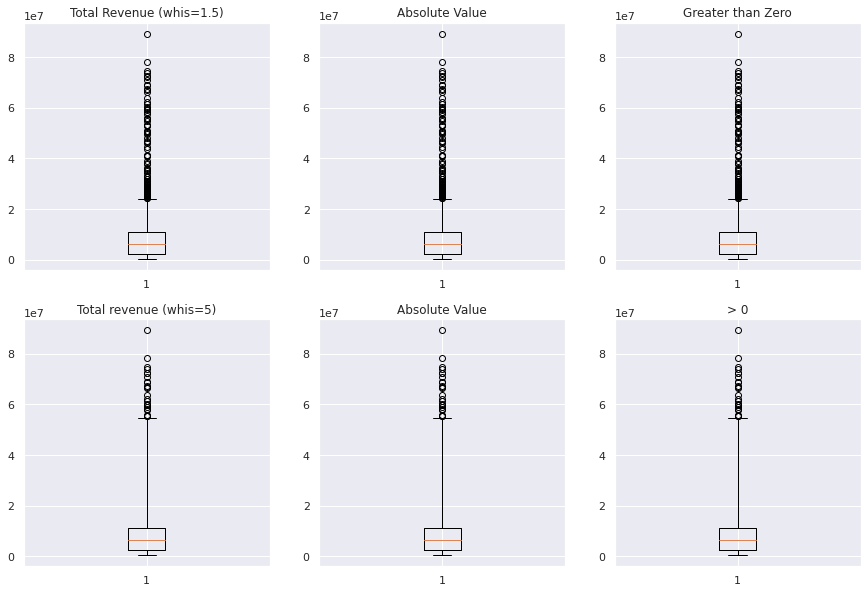

In [ ]:
#OUTLIER DATAFRAME
od = cleandf[['TOTAL_REVENUE', 'TOTAL_EXPENDITURE']]

#threshold for the boxplot whiskers, in the second row. "good" Thresholds are 1.5, 2, 3, and 5
t = 5

#Total Revenue with and without absolute value of average scores.
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.boxplot(od['TOTAL_REVENUE'])
plt.title("Total Revenue (whis=1.5)")

plt.subplot(2,3,2)
plt.boxplot(od['TOTAL_REVENUE'].abs())
plt.title("Absolute Value")

plt.subplot(2,3,3)
dr =od[od['TOTAL_REVENUE'] > 0]['TOTAL_REVENUE']
plt.boxplot(dr)
plt.title("Greater than Zero")

plt.subplot(2,3,4)
plt.boxplot(od['TOTAL_REVENUE'], whis=t)
plt.title("Total revenue (whis=" + str(t) + ")")

plt.subplot(2,3,5)
plt.boxplot(od['TOTAL_REVENUE'].abs(), whis=t)
plt.title("Absolute Value")

plt.subplot(2,3,6)
dr =od[od['TOTAL_REVENUE'] > 0]['TOTAL_REVENUE']
plt.boxplot(dr, whis=t)
plt.title("> 0")
plt.show()


**Total Expenditure:**
> Whisker: The variable still contains fliers when evaluated with a threshold of five. According to the box plot, it contains outliers. 

In observing the impact of the filled values, I've plotted the data with the followinig for the averages.

* Negative
* Positive
* Filtered

While the positive imputations do impact the overall distribution, it is slight in appearance. It has no impact on the outliers. I will work with the positive imputations for the outlier portion of the data cleaning until another observation changes my instincts.

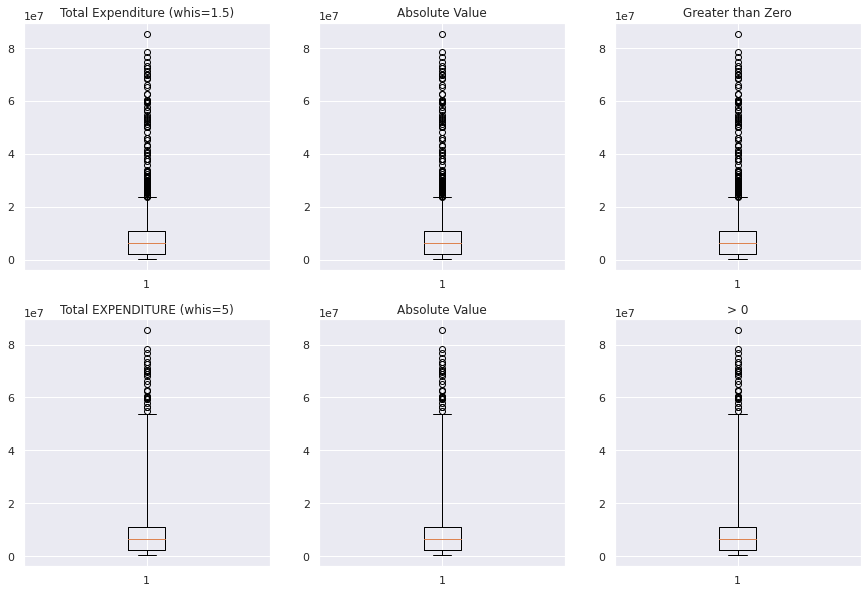

In [ ]:
#TOTAL EXPENDITURE
dr =od[od['TOTAL_EXPENDITURE'] > 0]['TOTAL_EXPENDITURE']

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.boxplot(od['TOTAL_EXPENDITURE'])
plt.title("Total Expenditure (whis=1.5)")

plt.subplot(2,3,2)
plt.boxplot(od['TOTAL_EXPENDITURE'].abs())
plt.title("Absolute Value")

plt.subplot(2,3,3)
plt.boxplot(dr)
plt.title("Greater than Zero")

plt.subplot(2,3,4)
plt.boxplot(od['TOTAL_EXPENDITURE'], whis=t)
plt.title("Total EXPENDITURE (whis=" + str(t) + ")")

plt.subplot(2,3,5)
plt.boxplot(od['TOTAL_EXPENDITURE'].abs(), whis=t)
plt.title("Absolute Value")

plt.subplot(2,3,6)
plt.boxplot(dr, whis=t)
plt.title("> 0")
plt.show()

####Histogram

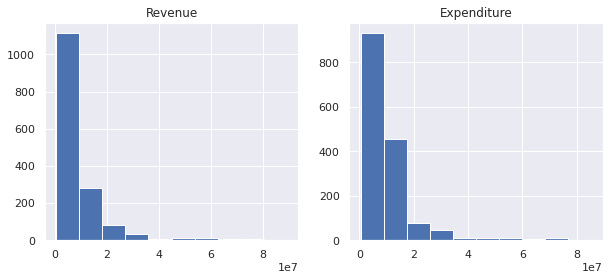

In [ ]:
#Decided on positive values for missing values. 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
od['TOTAL_REVENUE'].abs().hist()
plt.title("Revenue")
 
plt.subplot(1,2,2)
od['TOTAL_EXPENDITURE'].abs().hist()
plt.title("Expenditure")
plt.show()

####Z-Scores

Use scipy's z-score function to observe outliers.



```
# considering a snipped or function. 
def print_zscore(field):
  z_scores = stats.zscore(field)
  for threshold in range(1,5):
      print("The score threshold is: {}".format(threshold))
      print("The indices of the outliers:")
      print(np.where(z_scores > threshold))
      print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

```



In [ ]:
import numpy as np
z_scores = stats.zscore(od['TOTAL_REVENUE'].abs())
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([ 138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
        149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
        160,  161,  162,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  476,  477,  478,  479,  480,  481,
        482,  483,  484,  485,  486,  487,  488,  705,  706,  903,  904,
        905,  906,  907,  908,  909,  910,  911,  912,  913,  914,  915,
        941,  942,  943,  944,  945,  946,  947,  948,  949,  950,  951,
        952,  953,  954,  955,  956,  957,  958,  959,  960,  961,  962,
        963,  964,  965, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127,
       1128, 1129, 1130, 1131, 1132, 1258, 1260, 1261, 1262, 1263, 1264,
       1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275,
       1276, 1277, 1278, 1279, 1280, 1281]),)
Number of outliers is:

In [ ]:
z_scores = stats.zscore(od['TOTAL_EXPENDITURE'].abs())
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([ 138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
        149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
        160,  161,  162,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  474,  475,  476,  477,  478,  479,
        480,  481,  482,  483,  484,  485,  486,  487,  488,  703,  704,
        706,  903,  904,  905,  906,  907,  908,  909,  910,  911,  912,
        913,  914,  915,  941,  942,  943,  944,  945,  946,  947,  948,
        949,  950,  951,  952,  953,  954,  955,  956,  957,  958,  959,
        960,  961,  962,  963,  964,  965, 1047, 1048, 1049, 1050, 1051,
       1052, 1053, 1054, 1055, 1056, 1057, 1119, 1120, 1121, 1122, 1123,
       1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1261, 1262,
       1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273,
       1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281]),)
Number of 

####Tukey 

Tukey's Method 

```
# Considering creating a function or snippet.
def tukey(field):
  q75, q25 = np.percentile(field, [75 ,25])
  iqr = q75 - q25

  for threshold in np.arange(1,5,0.5):
      min_val = q25 - (iqr*threshold)
      max_val = q75 + (iqr*threshold)
      print("The score threshold is: {}".format(threshold))
      print("Number of outliers is: {}".format(
          len((np.where((field > max_val) 
                        | (field < min_val))[0]))
      ))
```



In [ ]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
q75, q25 = np.percentile(od['TOTAL_REVENUE'].abs(), [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((od['TOTAL_REVENUE'].abs() > max_val) 
                      | (od['TOTAL_REVENUE'].abs() < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 138
The score threshold is: 1.5
Number of outliers is: 105
The score threshold is: 2.0
Number of outliers is: 70
The score threshold is: 2.5
Number of outliers is: 50
The score threshold is: 3.0
Number of outliers is: 45
The score threshold is: 3.5
Number of outliers is: 39
The score threshold is: 4.0
Number of outliers is: 36
The score threshold is: 4.5
Number of outliers is: 30


In [ ]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
q75, q25 = np.percentile(od['TOTAL_EXPENDITURE'].abs(), [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((od['TOTAL_EXPENDITURE'].abs() > max_val) 
                      | (od['TOTAL_EXPENDITURE'].abs() < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 150
The score threshold is: 1.5
Number of outliers is: 110
The score threshold is: 2.0
Number of outliers is: 79
The score threshold is: 2.5
Number of outliers is: 55
The score threshold is: 3.0
Number of outliers is: 49
The score threshold is: 3.5
Number of outliers is: 42
The score threshold is: 4.0
Number of outliers is: 38
The score threshold is: 4.5
Number of outliers is: 35


###Resolve

Correct the outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables.

In [ ]:
# Make the job easy by updating the data frame to only include positive numbers
od = od.abs()
od.sort_values(by='TOTAL_REVENUE')

,TOTAL_REVENUE,TOTAL_EXPENDITURE
1208,465650.0,481665.0
1209,507927.0,525289.0
1207,551668.0,593126.0
1008,559481.0,553732.0
1009,580148.0,588983.0
...,...,...
153,72516936.0,73225422.0
155,73958896.0,74766086.0
154,74626928.0,76618865.0
161,78248042.0,78365958.0


#### DROP

Missing values in the financial tables were imputed as negative numbers to allow for a keen observation on whether or not to drop the missing data. 

Review the [box plot](https://colab.research.google.com/drive/1RMPVnYdAc5DcSteOVOgRCasJwmyJqPSE#scrollTo=bEM7_7aktuWd&line=1&uniqifier=1) explanation in this notebook in order to see an example of that process. 

The decision is (as stated at the initial resolve) to access the absolute value of these fields as the outliers (fliers) registered within a normal threshhold for the data.   

####LIMIT - Winsorize

One way to handle outliers is to limit the variables in a masked array so that the outliers are no longer apparent on the plot.

Winsorize has a one and two way distribution.

The outliers in both revenue and expenditure are one way. We want to impact the highest valules of the distribution.



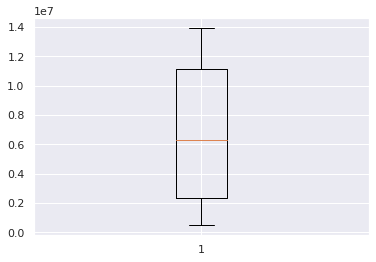

In [ ]:
#Windsorize
from scipy.stats.mstats import winsorize

# Apply one-way winsorization to the highest end. I went with the 80th percentile. 
wv1 = winsorize(od['TOTAL_REVENUE'], (0, 0.20))
plt.boxplot(wv1)
plt.show()

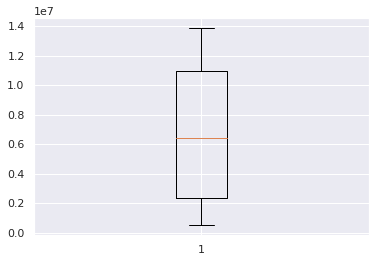

In [ ]:
# Apply one-way winsorization to the highest end. I went with the 80th percentile. 
wv2 = winsorize(od['TOTAL_EXPENDITURE'], (0, 0.20))
plt.boxplot(wv2)
plt.show()

####Transform


Monotonic Transformation are the most common type of transformations. 

They include log or square tranformation to normalize the values. 

Add new columns that contained the transformed values to the dataframe, od.


```
# This is formatted as code
od['LOG_TR'] = np.log(od['TOTAL_REVENUE'])
od['LOG_TE'] = np.log(od['TOTAL_EXPENDITURE'])
```




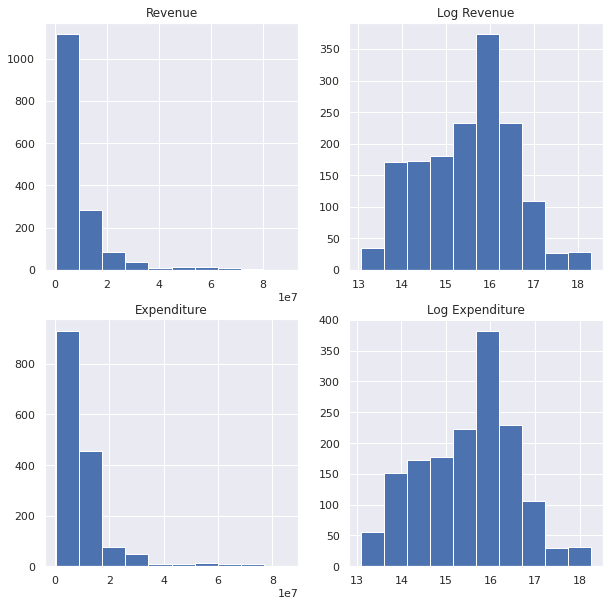

In [ ]:
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
plt.hist(od['TOTAL_REVENUE'])
plt.title("Revenue")

plt.subplot(2,2,2)
plt.hist(np.log(od['TOTAL_REVENUE']))
plt.title("Log Revenue")

plt.subplot(2,2,3)
plt.hist(od['TOTAL_EXPENDITURE'])
plt.title("Expenditure")

plt.subplot(2,2,4)
plt.hist(np.log(od['TOTAL_EXPENDITURE']))
plt.title("Log Expenditure")

plt.show()

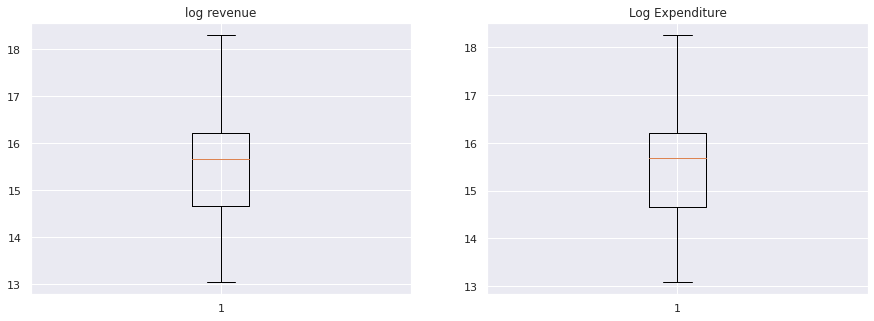

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(np.log(od['TOTAL_REVENUE']))
plt.title("log revenue")

plt.subplot(1,2,2)
plt.boxplot(np.log(od['TOTAL_EXPENDITURE']))
plt.title("Log Expenditure")
plt.show()

In [ ]:
# Considering creating a function or snippet.
def tukey(field):
  q75, q25 = np.percentile(field, [75 ,25])
  iqr = q75 - q25
 
  for threshold in np.arange(1,5,0.5):
      min_val = q25 - (iqr*threshold)
      max_val = q75 + (iqr*threshold)
      print("The score threshold is: {}".format(threshold))
      print("Number of outliers is: {}".format(
          len((np.where((field > max_val) 
                        | (field < min_val))[0]))
      ))

tukey(np.log(od['TOTAL_REVENUE']))

The score threshold is: 1.0
Number of outliers is: 29
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [ ]:
tukey(np.log(od['TOTAL_EXPENDITURE']))

The score threshold is: 1.0
Number of outliers is: 33
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [ ]:
od['LOG_TR'] = np.log(od['TOTAL_REVENUE'])
od['LOG_TE'] = np.log(od['TOTAL_EXPENDITURE'])
od

,TOTAL_REVENUE,TOTAL_EXPENDITURE,LOG_TR,LOG_TE
0,2678885.0,2653798.0,14.800911,14.791502
1,2827391.0,2833433.0,14.854865,14.857000
2,2970223.0,3103266.0,14.904148,14.947966
3,3367437.0,3353363.0,15.029662,15.025474
4,3365113.0,3572283.0,15.028972,15.088715
...,...,...,...,...
1556,1664983.0,1670728.0,14.325325,14.328770
1557,1695967.0,1675477.0,14.343764,14.331608
1558,1772633.0,1775999.0,14.387977,14.389874
1559,1962874.0,1942406.0,14.489920,14.479438


#EXPLORING WITH OTHER VARIABLES
Budget deficit in education.

In [ ]:
od. describe()

,TOTAL_REVENUE,TOTAL_EXPENDITURE,LOG_TR,LOG_TE
count,1.561000e+03,1.561000e+03,1561.000000,1561.000000
mean,9.159962e+06,9.280802e+06,15.510815,15.519122
std,1.079069e+07,1.100961e+07,1.052627,1.057052
min,4.656500e+05,4.816650e+05,13.051190,13.085004
25%,2.357828e+06,2.326473e+06,14.673251,14.659864
50%,6.297242e+06,6.398065e+06,15.655622,15.671506
75%,1.113997e+07,1.091791e+07,16.226050,16.205915
max,8.921726e+07,8.532013e+07,18.306585,18.261921


Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE 

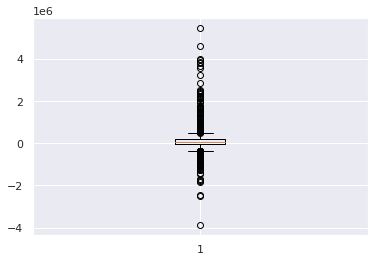

In [ ]:
od['DEFICIT'] = od['TOTAL_EXPENDITURE'] - od['TOTAL_REVENUE']
plt.boxplot(od['DEFICIT'])
plt.show()

There are a lot of outliers in this newly calculated field. 

There are negative values in this field, so a monotonic transformation will not help. 
Winsorize the data to eliminate outliers.

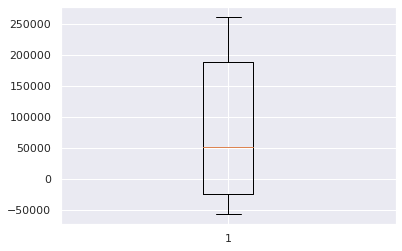

In [ ]:
# Apply two-way winsorization to the highest end. I went with the 80th percentile. 
wv1 = winsorize(od['DEFICIT'], (0.2, 0.2))
plt.boxplot(wv1)
plt.show()

It is possible that these extra outliers were caused by the decision to input all missing revenue and expidenture as an average. 

I consider - in this case - that dropping the missing values would have a better impact (that data for which the revenue or expenditure was < 0).

Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.


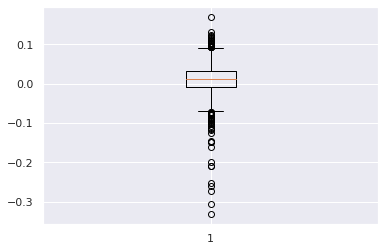

In [ ]:
od['DEFICIT_TWO'] = od['LOG_TE'] - od['LOG_TR']
plt.boxplot(od['DEFICIT_TWO'])
plt.show()

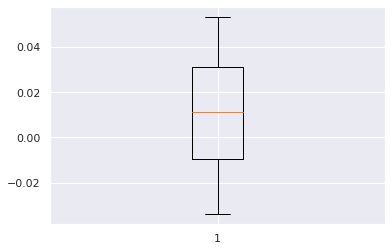

In [ ]:
# Apply two-way winsorization to the highest end. I went with the 90th percentile. 
wv1 = winsorize(od['DEFICIT_TWO'], (0.1, 0.1))
plt.boxplot(wv1)
plt.show()

Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?


In [ ]:
od[['DEFICIT', 'DEFICIT_TWO']].describe()

,DEFICIT,DEFICIT_TWO
count,1.561000e+03,1561.000000
mean,1.208398e+05,0.008307
std,5.254543e+05,0.040792
min,-3.897129e+06,-0.332627
25%,-2.508700e+04,-0.009573
50%,5.080200e+04,0.011439
75%,1.886710e+05,0.031210
max,5.487742e+06,0.170369


In [ ]:
tukey(od['DEFICIT'])

The score threshold is: 1.0
Number of outliers is: 359
The score threshold is: 1.5
Number of outliers is: 222
The score threshold is: 2.0
Number of outliers is: 163
The score threshold is: 2.5
Number of outliers is: 132
The score threshold is: 3.0
Number of outliers is: 105
The score threshold is: 3.5
Number of outliers is: 93
The score threshold is: 4.0
Number of outliers is: 79
The score threshold is: 4.5
Number of outliers is: 74


In [ ]:
tukey(od['DEFICIT_TWO'])

The score threshold is: 1.0
Number of outliers is: 171
The score threshold is: 1.5
Number of outliers is: 69
The score threshold is: 2.0
Number of outliers is: 29
The score threshold is: 2.5
Number of outliers is: 17
The score threshold is: 3.0
Number of outliers is: 13
The score threshold is: 3.5
Number of outliers is: 9
The score threshold is: 4.0
Number of outliers is: 8
The score threshold is: 4.5
Number of outliers is: 8


If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

I have fewer outliers when working with the monotonic transformations. 

First using a monotonic approach to the fields I'm calculating on and then performing a winsorization on a resulting variable with values < 0 would be the more appropriate approach.

# Feature Engineering

Work with the cleandf dataframe to lean and explore feature engineering concepts.

In [ ]:
cleandf.head()

,STATE,YEAR,ENROLL,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,ALABAMA,1992,727716.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,263.436257,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,0.0,174053.0
1,ALABAMA,1993,727716.0,8264.0,56598.0,57497.0,60004.0,39900.0,470775.0,198651.0,677690.0,234.301986,278.047397,218.630267,263.436257,2827391.0,331409.0,1729295.0,766687.0,2833433.0,1564558.0,794146.0,237222.0,204207.0
2,ALABAMA,1994,730004.0,9051.0,57723.0,56773.0,59165.0,41730.0,468472.0,201285.0,678808.0,234.301986,278.047397,218.630267,263.436257,2970223.0,331823.0,1850894.0,787506.0,3103266.0,1697593.0,826442.0,306977.0,231508.0
3,ALABAMA,1995,727480.0,9324.0,59739.0,56486.0,59914.0,40981.0,470246.0,206840.0,686410.0,234.301986,278.047397,218.630267,263.436257,3367437.0,328957.0,2161366.0,877114.0,3353363.0,1851700.0,888983.0,326956.0,243365.0
4,ALABAMA,1996,735912.0,9633.0,60949.0,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,935115.0,322883.0,286699.0


##Relationships

We want to understand the relationship between:
 
*   The expenditures of the governments  
*   Students' overall success in math and reading 


### The data frame
```
# Clean data frame for this exercise. 
es.head()
```

Column List Variables:

* cols 
* KEY
* EXPENDITURES
* SCORES   



In [ ]:
#Key value from the dataframe, for use when concatenating, merging, etc.
KEY = ['YEAR', 'STATE']
cols = KEY #All Columns I'm accessing.

#expenditure columns.
EXPENDITURES = ['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
cols.extend(EXPENDITURES)

#score columns.
SCORES = ['AVG_MATH_4_SCORE',	'AVG_MATH_8_SCORE',	'AVG_READING_4_SCORE',	'AVG_READING_8_SCORE']
cols.extend(SCORES)

#population column for weighted scoring.
POPULATION = ['GRADES_4_G',	'GRADES_8_G']
cols.extend(POPULATION)

#expenditures and score dataframe.
es = cleandf[cols]
es.head()

,YEAR,STATE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,GRADES_4_G,GRADES_8_G
0,1992,ALABAMA,1481703.0,735036.0,0.0,174053.0,208.327876,252.187522,207.963517,263.436257,57948.0,58025.0
1,1993,ALABAMA,1564558.0,794146.0,237222.0,204207.0,234.301986,278.047397,218.630267,263.436257,57497.0,60004.0
2,1994,ALABAMA,1697593.0,826442.0,306977.0,231508.0,234.301986,278.047397,218.630267,263.436257,56773.0,59165.0
3,1995,ALABAMA,1851700.0,888983.0,326956.0,243365.0,234.301986,278.047397,218.630267,263.436257,56486.0,59914.0
4,1996,ALABAMA,1987018.0,935115.0,322883.0,286699.0,211.646974,256.594863,210.920767,260.276441,57098.0,58305.0


In [ ]:
#Grade 8 population minus grade 4 population.
q = es.sum()
q['GRADES_4_G']- q['GRADES_8_G']

569827.5

###Average Scores

The average score for each row for all students weighted properly by grade.
* Each row will have its own average. 
* Weigh the scores.

>$Weighted grade = (w1×g1+ w2×g2+ w3×g3+...) / (w1+w2+w3+...)$
>
>$Weighted score = (p4(4m + 4r) + p8(8r + 8m))/ (p4 + p8)$ 

Where: 
* p4 = population of grade 4
* p8 = population of grade 8
* 4r, 4m = grade 4 reading and math scores, respectively.
* 8r, 8m = grade 8 reading and math scores, respectively.


Note: I reached out to NAEP regarding this calculation. While they were unable to provide a direct answer; further research as to the validility of this calculation and whether or not it is appropriate should/could be available [here](https://nces.ed.gov/training/datauser/#/national). I'd need more time to access it, though - so I cannot say that this is the "proper" way to weight the scores. 



In [ ]:
#es['AVG_SCORE'] = abs(es['GRADES_4_G']) * (abs(es['AVG_MATH_4_SCORE']) + abs(es['AVG_READING_4_SCORE'])) + abs(es['GRADES_8_G']) * (abs(es['AVG_MATH_8_SCORE']) + abs(es['AVG_READING_8_SCORE'])))/ (abs(es['GRADES_4_G']) + abs(es['GRADES_8_G']))
es['AVG_SCORE'] = (es['GRADES_4_G'] * (es['AVG_MATH_4_SCORE'] + es['AVG_READING_4_SCORE']) +
        es['GRADES_8_G'] * (es['AVG_MATH_8_SCORE'] + es['AVG_READING_8_SCORE']))/(es['GRADES_4_G'] + es['GRADES_8_G'])
es.head()

,YEAR,STATE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,GRADES_4_G,GRADES_8_G,AVG_SCORE
0,1992,ALABAMA,1481703.0,735036.0,0.0,174053.0,208.327876,252.187522,207.963517,263.436257,57948.0,58025.0,465.990562
1,1993,ALABAMA,1564558.0,794146.0,237222.0,204207.0,234.301986,278.047397,218.630267,263.436257,57497.0,60004.0,498.152619
2,1994,ALABAMA,1697593.0,826442.0,306977.0,231508.0,234.301986,278.047397,218.630267,263.436257,56773.0,59165.0,498.121437
3,1995,ALABAMA,1851700.0,888983.0,326956.0,243365.0,234.301986,278.047397,218.630267,263.436257,56486.0,59914.0,498.511881
4,1996,ALABAMA,1987018.0,935115.0,322883.0,286699.0,211.646974,256.594863,210.920767,260.276441,57098.0,58305.0,470.212683


In [ ]:
(es['GRADES_4_G'].sum() + es['GRADES_8_G'].sum())

188127474.5

###Correlation

* Correlations between this newly created score variable and the expenditure types 
* Most correlated expendenditure

*EXPENDITURES is a constant defined at the beginning of this notebook. It is a list of columns that contain all the expenditures.*

In [ ]:
max = 0.0

for expenditure in EXPENDITURES:
  correlation = es['AVG_SCORE'].corr(es[expenditure])
  print("The correlation score for {} is {} ".format(expenditure, correlation ))
  if correlation >= max:
    max = correlation
    best = expenditure
print("The greatest correlation of expenditures against the average score is {}".format(best)) 

The correlation score for INSTRUCTION_EXPENDITURE is 0.08641072544272795 
The correlation score for SUPPORT_SERVICES_EXPENDITURE is 0.08165835562337753 
The correlation score for OTHER_EXPENDITURE is 0.0918387137282721 
The correlation score for CAPITAL_OUTLAY_EXPENDITURE is 0.037892956315528026 
The greatest correlation of expenditures against the average score is OTHER_EXPENDITURE


###Principal Component Analysis (PCA)

```
# The following libraries are used in PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
```
PCA Rules:

* normally distributed data 
* linear relationships among variables 
* variables involved range from weak to moderately strong correlations. 
> * Correlations of 0, or correlations greater than .7 or .8, create problems. 
> * Correlations near 0 mean there is no shared information. 
> * Correlations that are too high can result in components that are unstable
> * A few very high or very low correlations are fine


*The correlations between expenditures and the average score are greater than zero and less than 0.7. The data was normalized and so they are eligible for PCA.*





#### Application

Apply PCA to the 4 expenditure types.

93% or 0.93 of the total variance can be explained by the first component. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(es[EXPENDITURES])

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the expenditure dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)



The percentage of total variance in the expenditure dataset explained by each component from Sklearn PCA.
 [0.9348967  0.03406303 0.02668999 0.00435028]


#### Evaluation
What is the correlation between the overall score variable and the 1st principal component?

In [ ]:
principalDf = pd.DataFrame(data = Y_sklearn, columns = ['com1', 'com2', 'com3', 'com4'])
principalDf

,com1,com2,com3,com4
0,-1.278829,0.113108,0.053163,0.016757
1,-1.016248,-0.220879,-0.148707,0.085455
2,-0.919628,-0.309401,-0.199734,0.113792
3,-0.871444,-0.318345,-0.218717,0.120640
4,-0.838423,-0.300859,-0.192170,0.123178
...,...,...,...,...
1556,-1.297717,-0.054031,0.065037,0.017615
1557,-1.297650,-0.051570,0.066282,0.015847
1558,-1.265523,-0.058340,0.117840,0.017434
1559,-1.210020,-0.075786,0.199217,0.022538


In [ ]:
principalDf['com1'].corr(es['AVG_SCORE'])

0.07705389174234437

#### Conclusion

If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

I have got to want to work with the component on this one and get rid of the expenditures. They have a high enough correlation to each other, which means that they're good candidates to reduce to a single component.

I want to work with the component because of the number of errors and amount of time that I spent constructing a "normalized" and "clean" dataset.

In reviewing my solution against the solution provided by in the assignment, I have achieved very different answers to the questions you're asking. 

If I had run the PCA on these variables and worked with the first component, I would not have had these errors. A lot of time would have been saved.


ON THE OTHER HAND: There is a total expenditure column. Would I prefer to use the Total Expenditure to the other columnns and/or the PCA? I have the PCA now. What's the correlation between those two? 

*Notice: We got different correlations.*